In [1]:
import os
import numpy as np
import pandas as pd
import mne 
from mne.io import read_raw_gdf
from mne.decoding import CSP
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from mne.preprocessing import ICA
import mne.preprocessing

**Read Data and Preprocessing**

![Screenshot 2024-05-09 201921.png](<attachment:Screenshot 2024-05-09 201921.png>)

**Events ID**

 {'1023': 1,
  '1072': 2,
  '276': 3,
  '277': 4,
  '32766': 5,
  '768': 6,
  '769': 7,
  '770': 8,
  '771': 9,
  '772': 10}
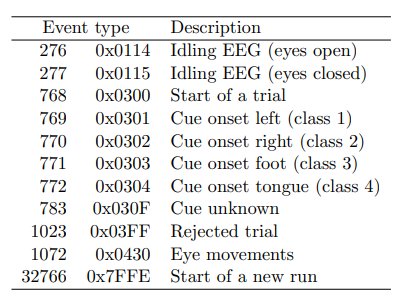

In [2]:
def prepare_data(path):
    raw = mne.io.read_raw_gdf(path, preload=True, eog=['EOG-left', 'EOG-central', 'EOG-right'])
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
    raw.set_eeg_reference()
    events = mne.events_from_annotations(raw)
    epochs = mne.Epochs(raw, events[0], event_id=[7, 8], tmin=-0.1, tmax=0.7, on_missing='warn', preload=True)
    
    

    # Apply ICA to remove eye blink artifacts
    ica = mne.preprocessing.ICA(n_components=22, random_state=97)
    ica.fit(raw)
    ica.exclude = [0]  # Exclude the first component (usually related to eye blinks)
    ica.apply(epochs)

    # Apply bandpass filter to preserve alpha and beta bands
    # raw.filter(7, 30, fir_design='firwin')
    
    labels = epochs.events[:, -1]
    features = epochs.get_data()
    
    # Filter EEG data for alpha and beta bands
    alpha_band = (7, 13)  # Define alpha band frequency range
    beta_band = (13, 30)  # Define beta band frequency range

    # Apply bandpass filtering to each epoch
    alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
                                                     h_freq=alpha_band[1], verbose=False)
    beta_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=beta_band[0],
                                                    h_freq=beta_band[1], verbose=False)
    

    print(" ")
    print("Features of", path, alpha_filtered_features.shape, beta_filtered_features.shape)
    print(" ")
    return alpha_filtered_features, beta_filtered_features, labels

In [3]:
# Path to the folder containing .gdf files
folder_path = "C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf"

# List all files in the folder
file_list = os.listdir(folder_path)

print("*********************", file_list)
# Initialize empty lists to store features and labels
all_aplha_features = []
all_beta_features = []
all_labels = []

# Loop through each file in the folder
for file_name in file_list:
    # Check if the file is a .gdf file
    if file_name.endswith('.gdf'):
        # Construct the full file path
        file_path = os.path.join(folder_path, file_name)
        
        # Read the data and apply preprocessing
        alpha_features, beta_features, labels = prepare_data(file_path)
        # Append DataFrames to the respective lists
        all_aplha_features.append(alpha_features)
        all_beta_features.append(beta_features)
        all_labels.append(labels)

# Concatenate alpha and beta filtered features into arrays
alpha_filtered_features = np.concatenate(all_aplha_features, axis=0)
beta_filtered_features = np.concatenate(all_beta_features, axis=0)
labels = np.concatenate(all_labels, axis=0)

# Concatenate alpha and beta features
concatenated_features = np.concatenate((alpha_filtered_features, beta_filtered_features), axis=1)

********************* ['A01E.gdf', 'A01T.gdf', 'A02E.gdf', 'A02T.gdf', 'A03E.gdf', 'A03T.gdf', 'A04E.gdf', 'A04T.gdf', 'A05E.gdf', 'A05T.gdf', 'A06E.gdf', 'A06T.gdf', 'A07E.gdf', 'A07T.gdf', 'A08E.gdf', 'A08T.gdf', 'A09E.gdf', 'A09T.gdf']
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Reading 0 ... 686999  =      0.000 ...  2747.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 original time points ...
0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:6: RuntimeWarning: No matching events found for 8 (event id 8)
  epochs = mne.Epochs(raw, events[0], event_id=[7, 8], tmin=-0.1, tmax=0.7, on_missing='warn', preload=True)


Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.9) and smallest (6e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 23.5s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A01E.gdf (288, 22, 201) (288, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
144 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 144 events and 201 original time points ...
0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (10) and smallest (5.9e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 14.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A01T.gdf (144, 22, 201) (144, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A02E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 662665  =      0.000 ...  2650.660 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 original time points ...
0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:6: RuntimeWarning: No matching events found for 8 (event id 8)
  epochs = mne.Epochs(raw, events[0], event_id=[7, 8], tmin=-0.1, tmax=0.7, on_missing='warn', preload=True)


Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (10) and smallest (8.2e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 17.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A02E.gdf (288, 22, 201) (288, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 677168  =      0.000 ...  2708.672 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
144 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 144 events and 201 original time points ...
0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (12) and smallest (6.7e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 25.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A02T.gdf (144, 22, 201) (144, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A03E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 648774  =      0.000 ...  2595.096 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 original time points ...
0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:6: RuntimeWarning: No matching events found for 8 (event id 8)
  epochs = mne.Epochs(raw, events[0], event_id=[7, 8], tmin=-0.1, tmax=0.7, on_missing='warn', preload=True)


Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (11) and smallest (5.7e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 17.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A03E.gdf (288, 22, 201) (288, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 660529  =      0.000 ...  2642.116 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
144 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 144 events and 201 original time points ...
0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (13) and smallest (4.5e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 26.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A03T.gdf (144, 22, 201) (144, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A04E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 660046  =      0.000 ...  2640.184 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 original time points ...
0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:6: RuntimeWarning: No matching events found for 8 (event id 8)
  epochs = mne.Epochs(raw, events[0], event_id=[7, 8], tmin=-0.1, tmax=0.7, on_missing='warn', preload=True)


Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (13) and smallest (4e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 16.7s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A04E.gdf (288, 22, 201) (288, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '32766', '768', '769', '770', '771', '772']
Not setting metadata
144 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 144 events and 201 original time points ...
0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (11) and smallest (5.4e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 22.4s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A04T.gdf (144, 22, 201) (144, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A05E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 679862  =      0.000 ...  2719.448 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 original time points ...


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:6: RuntimeWarning: No matching events found for 8 (event id 8)
  epochs = mne.Epochs(raw, events[0], event_id=[7, 8], tmin=-0.1, tmax=0.7, on_missing='warn', preload=True)


0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (10) and smallest (5.7e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 17.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A05E.gdf (288, 22, 201) (288, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 686119  =      0.000 ...  2744.476 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
144 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 144 events and 201 original time points ...
0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.7) and smallest (8.9e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 15.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A05T.gdf (144, 22, 201) (144, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A06E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 666372  =      0.000 ...  2665.488 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 original time points ...
0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:6: RuntimeWarning: No matching events found for 8 (event id 8)
  epochs = mne.Epochs(raw, events[0], event_id=[7, 8], tmin=-0.1, tmax=0.7, on_missing='warn', preload=True)


Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.4) and smallest (3.5e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 14.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A06E.gdf (288, 22, 201) (288, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 678979  =      0.000 ...  2715.916 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
144 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 144 events and 201 original time points ...
0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.7) and smallest (3.4e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 18.5s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A06T.gdf (144, 22, 201) (144, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A07E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 673134  =      0.000 ...  2692.536 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 original time points ...


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:6: RuntimeWarning: No matching events found for 8 (event id 8)
  epochs = mne.Epochs(raw, events[0], event_id=[7, 8], tmin=-0.1, tmax=0.7, on_missing='warn', preload=True)


0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (14) and smallest (3.5e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 17.9s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A07E.gdf (288, 22, 201) (288, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 681070  =      0.000 ...  2724.280 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
144 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 144 events and 201 original time points ...
0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (13) and smallest (4.3e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 13.7s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A07T.gdf (144, 22, 201) (144, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A08E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 687791  =      0.000 ...  2751.164 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 original time points ...
0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:6: RuntimeWarning: No matching events found for 8 (event id 8)
  epochs = mne.Epochs(raw, events[0], event_id=[7, 8], tmin=-0.1, tmax=0.7, on_missing='warn', preload=True)


Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (12) and smallest (3.5e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 28.8s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A08E.gdf (288, 22, 201) (288, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 675269  =      0.000 ...  2701.076 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
144 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 144 events and 201 original time points ...
0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (11) and smallest (3.1e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 15.5s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A08T.gdf (144, 22, 201) (144, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A09E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 675097  =      0.000 ...  2700.388 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 original time points ...
0 bad epochs dropped


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:6: RuntimeWarning: No matching events found for 8 (event id 8)
  epochs = mne.Epochs(raw, events[0], event_id=[7, 8], tmin=-0.1, tmax=0.7, on_missing='warn', preload=True)


Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.8) and smallest (2e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 14.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A09E.gdf (288, 22, 201) (288, 22, 201)
 
Extracting EDF parameters from C:\Users\Malak\Documents\Semester 8\HCI\Project\BCICIV_2a_gdf\A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 673327  =      0.000 ...  2693.308 secs...


c:\Users\Malak\anaconda3\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
144 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 144 events and 201 original time points ...
0 bad epochs dropped
Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 22 components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:12: RuntimeWarning: Using n_components=22 (resulting in n_components_=22) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.7) and smallest (2.3e-29) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica.fit(raw)


Fitting ICA took 21.0s.
Applying ICA to Epochs instance
    Transforming to ICA space (22 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:14: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  features = epochs.get_data()
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:27: RuntimeWarning: filter_length (413) is longer than the signal (201), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_filtered_features = mne.filter.filter_data(features, sfreq=raw.info['sfreq'], l_freq=alpha_band[0],
C:\Users\Malak\AppData\Local\Temp\ipykernel_18792\2435330820.py:29: RuntimeWarning: filter_length (255) is longer than the signal (201), distortion is likely. Re

 
Features of C:/Users/Malak/Documents/Semester 8/HCI/Project/BCICIV_2a_gdf\A09T.gdf (144, 22, 201) (144, 22, 201)
 


In [4]:
# Verify the shapes of the concatenated features
print("Alpha filtered features shape:", alpha_filtered_features.shape)
print("Beta filtered features shape:", beta_filtered_features.shape)
print("Labels shape:", labels.shape)
print("concatenated_features shape:", concatenated_features.shape)

Alpha filtered features shape: (3888, 22, 201)
Beta filtered features shape: (3888, 22, 201)
Labels shape: (3888,)
concatenated_features shape: (3888, 44, 201)


In [5]:

'''import os
import numpy as np
import mne
from sklearn.decomposition import PCA

 
def apply_pca(features, n_components):
    # Reshape the features array to be 2D
    num_samples, num_channels, num_timepoints = features.shape
    features_2d = features.reshape(num_samples, num_channels * num_timepoints)
 
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(features_2d)
 
    return pca_features


def extract_csp_features(features, labels, n_components):
    # Determine the number of channels
    num_channels = features.shape[1]
 
    # Reshape the features array based on the number of channels
    num_samples = features.shape[0]
    num_remaining_dimensions = features.size // (num_samples * num_channels)
    features_3d = features.reshape(num_samples, num_channels, num_remaining_dimensions)
 
    csp = mne.decoding.CSP(n_components=n_components, reg=None, log=True, norm_trace=False)
    csp.fit_transform(features_3d, labels)
    csp_features = csp.transform(features_3d)
 
    return csp_features

# Apply PCA to the concatenated features
n_components_pca = 22  # Specify the desired number of PCA components
pca_features = apply_pca(concatenated_features, n_components_pca)
print("pcs ",pca_features.shape)

# Extract CSP features from the PCA features
n_components_csp = 22  # Specify the desired number of CSP components
csp_features = extract_csp_features(pca_features, labels, n_components_csp)'''


'import os\nimport numpy as np\nimport mne\nfrom sklearn.decomposition import PCA\n\n \ndef apply_pca(features, n_components):\n    # Reshape the features array to be 2D\n    num_samples, num_channels, num_timepoints = features.shape\n    features_2d = features.reshape(num_samples, num_channels * num_timepoints)\n \n    pca = PCA(n_components=n_components)\n    pca_features = pca.fit_transform(features_2d)\n \n    return pca_features\n\n\ndef extract_csp_features(features, labels, n_components):\n    # Determine the number of channels\n    num_channels = features.shape[1]\n \n    # Reshape the features array based on the number of channels\n    num_samples = features.shape[0]\n    num_remaining_dimensions = features.size // (num_samples * num_channels)\n    features_3d = features.reshape(num_samples, num_channels, num_remaining_dimensions)\n \n    csp = mne.decoding.CSP(n_components=n_components, reg=None, log=True, norm_trace=False)\n    csp.fit_transform(features_3d, labels)\n    csp

In [6]:
'''def segment_data(data):
    # Segment the data into epochs of fixed duration
    epoch_duration = 4.5  # Adjust the epoch duration as needed (in seconds)
    sampling_rate = 250  # Adjust the sampling rate as needed (in Hz)
    n_samples = int(epoch_duration * sampling_rate)
    n_epochs = data.shape[1] // n_samples
    segmented_data = np.reshape(data[:, :n_epochs * n_samples], (data.shape[0], n_epochs, n_samples))

    return segmented_data

segmented_data = segment_data(concatenated_features)'''

'def segment_data(data):\n    # Segment the data into epochs of fixed duration\n    epoch_duration = 4.5  # Adjust the epoch duration as needed (in seconds)\n    sampling_rate = 250  # Adjust the sampling rate as needed (in Hz)\n    n_samples = int(epoch_duration * sampling_rate)\n    n_epochs = data.shape[1] // n_samples\n    segmented_data = np.reshape(data[:, :n_epochs * n_samples], (data.shape[0], n_epochs, n_samples))\n\n    return segmented_data\n\nsegmented_data = segment_data(concatenated_features)'

**Feature Extraction**

In [7]:
def extract_csp_features(features, labels, n_components):
    csp = CSP(n_components=n_components, reg=None, log=True, norm_trace=False)
    csp.fit_transform(features, labels)
    csp_features = csp.transform(features)
    return csp_features

In [8]:
# Extract CSP features from the concatenated features
n_components = 22  # Specify the desired number of CSP components
csp_features = extract_csp_features(concatenated_features, labels, n_components)


Computing rank from data with rank=None
    Using tolerance 2.1e-05 (2.2e-16 eps * 44 dim * 2.1e+09  max singular value)
    Estimated rank (data): 44
    data: rank 44 computed from 44 data channels with 0 projectors
Reducing data rank from 44 -> 44
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.


**Split Data**

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(csp_features, labels, test_size=0.2, random_state=42)
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Classifiers**

In [10]:
# SVM hyperparameter tuning
svm_param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=5)
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_
svm_pred = best_svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
print("Best SVM Parameters:", svm_grid.best_params_)
print(f"SVM Accuracy after Hyperparameter Tuning: {svm_acc * 100:.3f}%")
print("SVM Classification Report:")
print(classification_report(y_test, svm_pred))
print(" ")

# Random Forest hyperparameter tuning
rf_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
rf_pred = best_rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print(" ")
print("Best Random Forest Parameters:", rf_grid.best_params_)
print(f"Random Forest Accuracy after Hyperparameter Tuning: {rf_acc * 100:.3f}%")
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))
print(" ")



Best SVM Parameters: {'C': 10, 'gamma': 'scale'}
SVM Accuracy after Hyperparameter Tuning: 86.118%
SVM Classification Report:
              precision    recall  f1-score   support

           7       0.89      0.95      0.92       654
           8       0.60      0.38      0.47       124

    accuracy                           0.86       778
   macro avg       0.75      0.67      0.69       778
weighted avg       0.84      0.86      0.85       778

 
 
Best Random Forest Parameters: {'max_depth': None, 'n_estimators': 300}
Random Forest Accuracy after Hyperparameter Tuning: 87.147%
Random Forest Classification Report:
              precision    recall  f1-score   support

           7       0.89      0.96      0.93       654
           8       0.67      0.39      0.49       124

    accuracy                           0.87       778
   macro avg       0.78      0.68      0.71       778
weighted avg       0.86      0.87      0.86       778

 


In [11]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression hyperparameter tuning
log_reg_param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
log_reg_grid = GridSearchCV(LogisticRegression(), log_reg_param_grid, cv=5)
log_reg_grid.fit(X_train, y_train)
best_log_reg = log_reg_grid.best_estimator_
log_reg_pred = best_log_reg.predict(X_test)
log_reg_acc = accuracy_score(y_test, log_reg_pred)
print("Best Logistic Regression Parameters:", log_reg_grid.best_params_)
print(f"Logistic Regression Accuracy after Hyperparameter Tuning: {log_reg_acc * 100:.3f}%")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_pred))
print(" ")


c:\Users\Malak\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Malak\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Malak\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Malak\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _

Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l2'}
Logistic Regression Accuracy after Hyperparameter Tuning: 84.576%
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           7       0.88      0.95      0.91       654
           8       0.53      0.31      0.39       124

    accuracy                           0.85       778
   macro avg       0.70      0.63      0.65       778
weighted avg       0.82      0.85      0.83       778

 


In [12]:
# KNN hyperparameter tuning
knn_param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5)
knn_grid.fit(X_train, y_train)
best_knn = knn_grid.best_estimator_
knn_pred = best_knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
print("Best KNN Parameters:", knn_grid.best_params_)
print(f"KNN Accuracy after Hyperparameter Tuning: {knn_acc * 100:.3f}%")
print("KNN Classification Report:")
print(classification_report(y_test, knn_pred))
print(" ")

Best KNN Parameters: {'n_neighbors': 7, 'weights': 'uniform'}
KNN Accuracy after Hyperparameter Tuning: 84.961%
KNN Classification Report:
              precision    recall  f1-score   support

           7       0.90      0.92      0.91       654
           8       0.53      0.48      0.50       124

    accuracy                           0.85       778
   macro avg       0.72      0.70      0.71       778
weighted avg       0.84      0.85      0.85       778

 


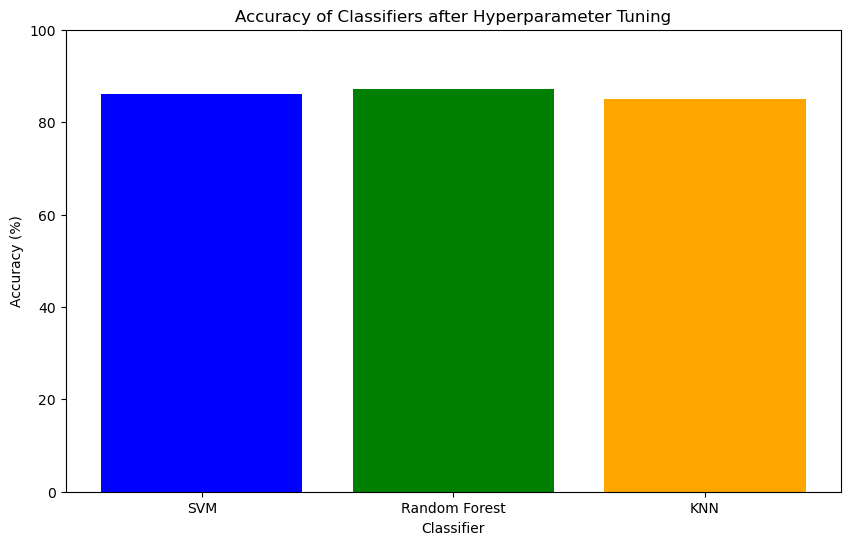

In [13]:
import matplotlib.pyplot as plt

# Define classifier names
classifiers = ['SVM', 'Random Forest', 'KNN']

# Define accuracy scores for each classifier
accuracy_scores = [svm_acc * 100, rf_acc * 100, knn_acc * 100]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(classifiers, accuracy_scores, color=['blue', 'green', 'orange'])
plt.xlabel('Classifier')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Classifiers after Hyperparameter Tuning')
plt.ylim(0, 100)  # Set y-axis limit
plt.show()


In [14]:
'''import tkinter as tk
from PIL import ImageTk, Image
import os
import time

class PhotoViewerApp:
 
    def __init__(self, master, orders):
        self.master = master
        self.current_index = 0
        self.orders = orders
        self.click_counter = 0  # Counter variable to track the number of clicks

        self.red = "#F08080"
        self.blue = "#1E90FF"

        # Path to the folder containing .gdf files
        folder_path = "C:/Users/Malak/Documents/Semester 8/HCI/Project/images"

        # List all files in the folder
        file_list = os.listdir(folder_path)
        
        self.image_filenames = []

        # Loop through each file in the folder
        for file_name in file_list:
            # Check if the file is a .gdf file
            if file_name.endswith('.jpeg'):
                # Construct the full file path
                file_path = os.path.join(folder_path, file_name)
                self.image_filenames.append(file_path)
   
        # Display initial image
        self.display_image()
        self.master.after(3000)

        # Create the buttons
        self.create_buttons()

        # Create the counter label
        self.create_counter_label() 

        self.auto_click_buttons()

    def create_buttons(self):
        # Create the buttons
        self.left_button = tk.Button(self.master, text="Left", command=self.prev_image, width=10, height=2, fg="white", bg=self.blue)
        self.right_button = tk.Button(self.master, text="Right", command=self.next_image, width=10, height=2, fg="white", bg=self.blue)
        # Position the buttons using pack geometry manager
        self.left_button.pack(side="left", padx=5, pady=5)
        self.right_button.pack(side="right", padx=5, pady=5)

    def create_counter_label(self):
        # Create the counter label
        self.counter_label = tk.Label(self.master, text="Clicks: 0")
        self.counter_label.pack()

    def prev_image(self):
        self.current_index = (self.current_index - 1) % len(self.image_filenames)
        #self.display_image()
        self.master.after(100, self.display_image)
        self.update_counter()  # Update the counter when a button is clicked
        
    def next_image(self):
        self.current_index = (self.current_index + 1) % len(self.image_filenames)
        #self.display_image()
        self.master.after(100, self.display_image)
        self.update_counter()  # Update the counter when a button is clicked

    def auto_click_buttons(self):
        self.current_index = 0
        for i, order in enumerate(self.orders):
            if order == "left":
                button_to_click = self.left_button
                self.prev_image()
                self.master.after(3000 * (i + 1), button_to_click.invoke)
            elif order == "right":
                button_to_click = self.right_button
                self.next_image()
                self.master.after(3000 * (i + 1), button_to_click.invoke)

    def display_image(self):
        # Load current image
        image_path = self.image_filenames[self.current_index]
        image = Image.open(image_path)
        image.thumbnail((300, 300))  # Resize image if necessary
        photo = ImageTk.PhotoImage(image)
        # Display image
        # Keep a reference to prevent garbage collection
        # Create a label to display the image if it doesn't exist
        if not hasattr(self, "image_label"):
            self.image_label = tk.Label(self.master)
            self.image_label.pack()
        # Configure the label to display the new image
        self.image_label.config(image=photo)
        self.image_label.image = photo  # Keep a reference to prevent garbage collection
    
    def update_counter(self):
        self.click_counter = self.current_index
        self.counter_label.config(text=f"Clicks: {self.click_counter}")  # Update the counter label
        
def main():
    orders = ['left', 'right', 'left']
    root = tk.Tk()
    app = PhotoViewerApp(root, orders)
    root.mainloop()
if __name__ == "__main__":
    main()'''

'import tkinter as tk\nfrom PIL import ImageTk, Image\nimport os\nimport time\n\nclass PhotoViewerApp:\n \n    def __init__(self, master, orders):\n        self.master = master\n        self.current_index = 0\n        self.orders = orders\n        self.click_counter = 0  # Counter variable to track the number of clicks\n\n        self.red = "#F08080"\n        self.blue = "#1E90FF"\n\n        # Path to the folder containing .gdf files\n        folder_path = "C:/Users/Malak/Documents/Semester 8/HCI/Project/images"\n\n        # List all files in the folder\n        file_list = os.listdir(folder_path)\n        \n        self.image_filenames = []\n\n        # Loop through each file in the folder\n        for file_name in file_list:\n            # Check if the file is a .gdf file\n            if file_name.endswith(\'.jpeg\'):\n                # Construct the full file path\n                file_path = os.path.join(folder_path, file_name)\n                self.image_filenames.append(file_path